In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import shap #Feature importance graph
import warnings

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from catboost import Pool, CatBoostRegressor, cv #catboost
from sklearn.model_selection import train_test_split #as it is

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warning from sklearn and seaborn

In [2]:
train = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/user/PycharmProjects/Sales-forecast/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.shape


(1460, 81)

In [4]:
test.shape

(1459, 80)

Deleting outliers

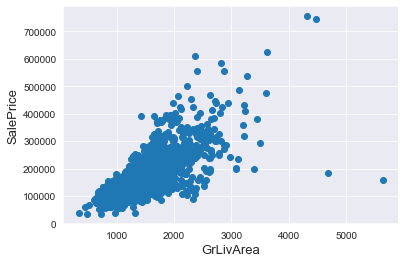

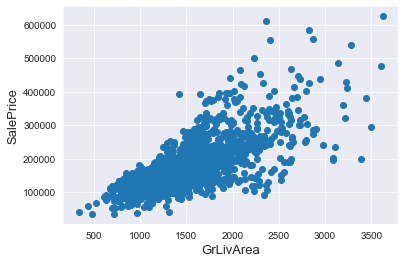

In [5]:
#show outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


Check and normalize the distribution


 mu = 180151.23 and sigma = 76670.25



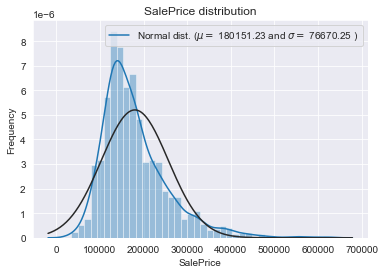

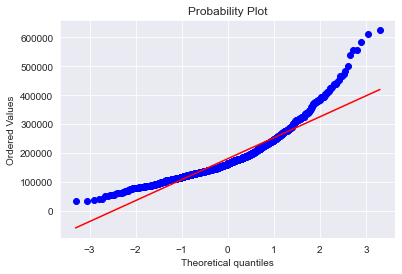

In [6]:
#SalePrice exploration
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()



 mu = 12.02 and sigma = 0.40



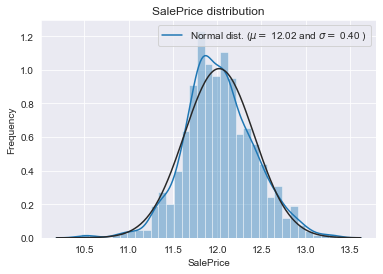

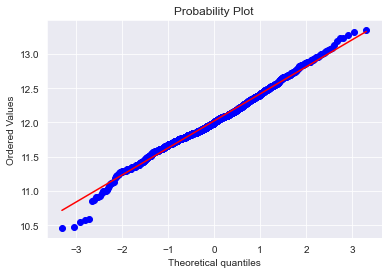

In [7]:
#The numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

Feature engineering

In [8]:
#concatenate data in the same dataframe
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2915, 80)


In [9]:
#calculate % of missing data
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.725557
MiscFeature,96.397942
Alley,93.207547
Fence,80.445969
FireplaceQu,48.713551
LotFrontage,16.672384
GarageFinish,5.454545
GarageYrBlt,5.454545
GarageQual,5.454545
GarageCond,5.454545


<AxesSubplot:>

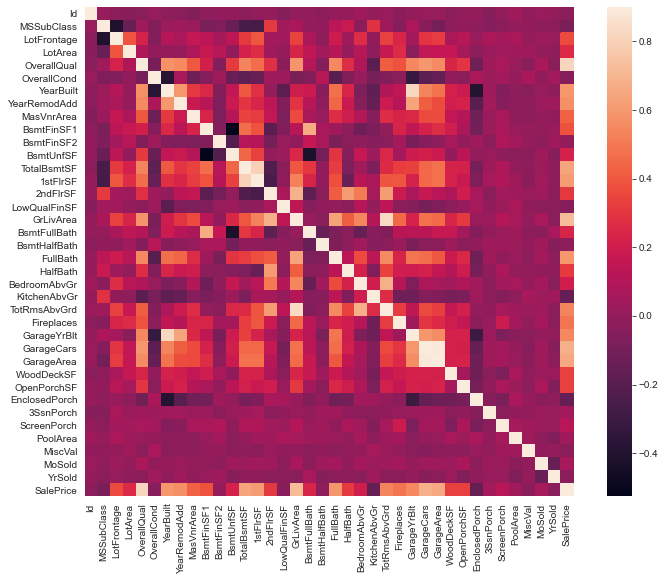

In [10]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [11]:
#fill up missing values


#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#Check whether it should be None or 0
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt','MasVnrArea', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MasVnrType','Electrical','Exterior1st', 'Exterior2nd','MSZoning', 'Utilities', 'SaleType', 'KitchenQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

#for Functional NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [12]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [13]:
#Transforming some numerical variables that are really categorical


all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


#Since area features are really important we can add one more as a sum.Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

Getting new train and test set

In [14]:
#rows from train dataset
train = all_data[:ntrain]
#rows since train dataset (test)
test = all_data[ntrain:]

Catboost

In [15]:
#Select all the categorial features
feat= np.where(train.dtypes == object)[0]
#split
X_train, X_val, y_train, y_val = train_test_split(train, y_train, train_size=0.8, random_state=1234)

train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=feat)
val_pool = Pool(X_val, y_val,
                 cat_features=feat) 

test_pool = Pool(test, cat_features = feat)


In [16]:
model = CatBoostRegressor(loss_function='RMSE', 
                                       random_seed=2, 
                                       max_depth = 10,
                                       learning_rate = 0.05,
                                       random_strength=1,
                                       max_ctr_complexity=1,
                                       l2_leaf_reg=8,
                                       grow_policy = 'Lossguide',
                                
                                      )

model.fit(train_pool, eval_set = val_pool)
print ('Model is fitted:', model.is_fitted())
print ('Model params:', model.get_params())
print ('Resulting tree count:', model.tree_count_)

0:	learn: 0.3883139	test: 0.3586611	best: 0.3586611 (0)	total: 91ms	remaining: 1m 30s
1:	learn: 0.3763892	test: 0.3472785	best: 0.3472785 (1)	total: 131ms	remaining: 1m 5s
2:	learn: 0.3646450	test: 0.3370486	best: 0.3370486 (2)	total: 171ms	remaining: 56.8s
3:	learn: 0.3538289	test: 0.3270316	best: 0.3270316 (3)	total: 207ms	remaining: 51.6s
4:	learn: 0.3432942	test: 0.3175962	best: 0.3175962 (4)	total: 245ms	remaining: 48.7s
5:	learn: 0.3332786	test: 0.3088941	best: 0.3088941 (5)	total: 282ms	remaining: 46.7s
6:	learn: 0.3231214	test: 0.2996386	best: 0.2996386 (6)	total: 334ms	remaining: 47.3s
7:	learn: 0.3149831	test: 0.2924394	best: 0.2924394 (7)	total: 372ms	remaining: 46.1s
8:	learn: 0.3069900	test: 0.2851821	best: 0.2851821 (8)	total: 411ms	remaining: 45.3s
9:	learn: 0.2988630	test: 0.2782531	best: 0.2782531 (9)	total: 445ms	remaining: 44.1s
10:	learn: 0.2901468	test: 0.2707154	best: 0.2707154 (10)	total: 476ms	remaining: 42.8s
11:	learn: 0.2821499	test: 0.2635617	best: 0.2635617

96:	learn: 0.1057553	test: 0.1359796	best: 0.1359796 (96)	total: 4.14s	remaining: 38.6s
97:	learn: 0.1052882	test: 0.1356753	best: 0.1356753 (97)	total: 4.18s	remaining: 38.5s
98:	learn: 0.1048150	test: 0.1355531	best: 0.1355531 (98)	total: 4.22s	remaining: 38.5s
99:	learn: 0.1043139	test: 0.1352204	best: 0.1352204 (99)	total: 4.28s	remaining: 38.5s
100:	learn: 0.1039348	test: 0.1351103	best: 0.1351103 (100)	total: 4.41s	remaining: 39.3s
101:	learn: 0.1034080	test: 0.1349175	best: 0.1349175 (101)	total: 4.56s	remaining: 40.2s
102:	learn: 0.1029820	test: 0.1347183	best: 0.1347183 (102)	total: 4.71s	remaining: 41s
103:	learn: 0.1025994	test: 0.1347480	best: 0.1347183 (102)	total: 5.14s	remaining: 44.3s
104:	learn: 0.1021438	test: 0.1346140	best: 0.1346140 (104)	total: 5.27s	remaining: 44.9s
105:	learn: 0.1018724	test: 0.1344226	best: 0.1344226 (105)	total: 5.43s	remaining: 45.8s
106:	learn: 0.1014960	test: 0.1342591	best: 0.1342591 (106)	total: 5.67s	remaining: 47.3s
107:	learn: 0.101284

191:	learn: 0.0817869	test: 0.1282137	best: 0.1282137 (191)	total: 11.3s	remaining: 47.6s
192:	learn: 0.0817301	test: 0.1281588	best: 0.1281588 (192)	total: 11.4s	remaining: 47.6s
193:	learn: 0.0814699	test: 0.1280733	best: 0.1280733 (193)	total: 11.4s	remaining: 47.5s
194:	learn: 0.0813137	test: 0.1281078	best: 0.1280733 (193)	total: 11.5s	remaining: 47.4s
195:	learn: 0.0812087	test: 0.1280656	best: 0.1280656 (195)	total: 11.5s	remaining: 47.3s
196:	learn: 0.0810298	test: 0.1280136	best: 0.1280136 (196)	total: 11.6s	remaining: 47.5s
197:	learn: 0.0809694	test: 0.1279958	best: 0.1279958 (197)	total: 11.7s	remaining: 47.5s
198:	learn: 0.0807176	test: 0.1279253	best: 0.1279253 (198)	total: 11.8s	remaining: 47.7s
199:	learn: 0.0804437	test: 0.1279130	best: 0.1279130 (199)	total: 12s	remaining: 47.8s
200:	learn: 0.0803060	test: 0.1278127	best: 0.1278127 (200)	total: 12s	remaining: 47.7s
201:	learn: 0.0801749	test: 0.1277309	best: 0.1277309 (201)	total: 12.1s	remaining: 47.9s
202:	learn: 0.

284:	learn: 0.0709495	test: 0.1258069	best: 0.1258069 (284)	total: 16.1s	remaining: 40.3s
285:	learn: 0.0707981	test: 0.1258154	best: 0.1258069 (284)	total: 16.1s	remaining: 40.2s
286:	learn: 0.0707343	test: 0.1257957	best: 0.1257957 (286)	total: 16.2s	remaining: 40.1s
287:	learn: 0.0706696	test: 0.1257949	best: 0.1257949 (287)	total: 16.2s	remaining: 40s
288:	learn: 0.0705690	test: 0.1258307	best: 0.1257949 (287)	total: 16.2s	remaining: 39.9s
289:	learn: 0.0705393	test: 0.1258348	best: 0.1257949 (287)	total: 16.3s	remaining: 39.9s
290:	learn: 0.0704461	test: 0.1257912	best: 0.1257912 (290)	total: 16.4s	remaining: 39.8s
291:	learn: 0.0702324	test: 0.1258272	best: 0.1257912 (290)	total: 16.4s	remaining: 39.8s
292:	learn: 0.0701211	test: 0.1258143	best: 0.1257912 (290)	total: 16.5s	remaining: 39.7s
293:	learn: 0.0700695	test: 0.1258015	best: 0.1257912 (290)	total: 16.5s	remaining: 39.7s
294:	learn: 0.0700347	test: 0.1257849	best: 0.1257849 (294)	total: 16.6s	remaining: 39.6s
295:	learn: 

380:	learn: 0.0629224	test: 0.1252317	best: 0.1252052 (358)	total: 21.7s	remaining: 35.3s
381:	learn: 0.0628347	test: 0.1252746	best: 0.1252052 (358)	total: 21.8s	remaining: 35.2s
382:	learn: 0.0627320	test: 0.1252994	best: 0.1252052 (358)	total: 21.9s	remaining: 35.3s
383:	learn: 0.0626251	test: 0.1253616	best: 0.1252052 (358)	total: 21.9s	remaining: 35.2s
384:	learn: 0.0626054	test: 0.1253554	best: 0.1252052 (358)	total: 22s	remaining: 35.1s
385:	learn: 0.0624159	test: 0.1254049	best: 0.1252052 (358)	total: 22s	remaining: 35s
386:	learn: 0.0622494	test: 0.1253557	best: 0.1252052 (358)	total: 22.1s	remaining: 35s
387:	learn: 0.0621396	test: 0.1253668	best: 0.1252052 (358)	total: 22.1s	remaining: 34.9s
388:	learn: 0.0620837	test: 0.1253642	best: 0.1252052 (358)	total: 22.1s	remaining: 34.8s
389:	learn: 0.0619562	test: 0.1253239	best: 0.1252052 (358)	total: 22.2s	remaining: 34.7s
390:	learn: 0.0619166	test: 0.1253249	best: 0.1252052 (358)	total: 22.2s	remaining: 34.6s
391:	learn: 0.0617

472:	learn: 0.0557053	test: 0.1250961	best: 0.1250210 (414)	total: 25.8s	remaining: 28.7s
473:	learn: 0.0556394	test: 0.1251046	best: 0.1250210 (414)	total: 25.8s	remaining: 28.6s
474:	learn: 0.0555014	test: 0.1251006	best: 0.1250210 (414)	total: 25.8s	remaining: 28.6s
475:	learn: 0.0554084	test: 0.1250806	best: 0.1250210 (414)	total: 25.9s	remaining: 28.5s
476:	learn: 0.0553436	test: 0.1250266	best: 0.1250210 (414)	total: 25.9s	remaining: 28.4s
477:	learn: 0.0552753	test: 0.1250044	best: 0.1250044 (477)	total: 25.9s	remaining: 28.3s
478:	learn: 0.0552497	test: 0.1249944	best: 0.1249944 (478)	total: 26s	remaining: 28.3s
479:	learn: 0.0552161	test: 0.1250061	best: 0.1249944 (478)	total: 26s	remaining: 28.2s
480:	learn: 0.0551087	test: 0.1250009	best: 0.1249944 (478)	total: 26.1s	remaining: 28.1s
481:	learn: 0.0550025	test: 0.1249653	best: 0.1249653 (481)	total: 26.1s	remaining: 28.1s
482:	learn: 0.0549364	test: 0.1249962	best: 0.1249653 (481)	total: 26.2s	remaining: 28s
483:	learn: 0.05

567:	learn: 0.0489347	test: 0.1250706	best: 0.1249582 (506)	total: 29.7s	remaining: 22.6s
568:	learn: 0.0488641	test: 0.1250444	best: 0.1249582 (506)	total: 29.7s	remaining: 22.5s
569:	learn: 0.0487803	test: 0.1250092	best: 0.1249582 (506)	total: 29.8s	remaining: 22.5s
570:	learn: 0.0487323	test: 0.1250126	best: 0.1249582 (506)	total: 29.8s	remaining: 22.4s
571:	learn: 0.0486669	test: 0.1250321	best: 0.1249582 (506)	total: 29.8s	remaining: 22.3s
572:	learn: 0.0485898	test: 0.1250254	best: 0.1249582 (506)	total: 29.9s	remaining: 22.3s
573:	learn: 0.0485201	test: 0.1250257	best: 0.1249582 (506)	total: 29.9s	remaining: 22.2s
574:	learn: 0.0485075	test: 0.1250384	best: 0.1249582 (506)	total: 30s	remaining: 22.1s
575:	learn: 0.0484043	test: 0.1250663	best: 0.1249582 (506)	total: 30s	remaining: 22.1s
576:	learn: 0.0483257	test: 0.1250760	best: 0.1249582 (506)	total: 30s	remaining: 22s
577:	learn: 0.0482622	test: 0.1251161	best: 0.1249582 (506)	total: 30.1s	remaining: 22s
578:	learn: 0.048224

662:	learn: 0.0435119	test: 0.1249378	best: 0.1248925 (657)	total: 33.7s	remaining: 17.1s
663:	learn: 0.0434476	test: 0.1249245	best: 0.1248925 (657)	total: 33.8s	remaining: 17.1s
664:	learn: 0.0433970	test: 0.1249204	best: 0.1248925 (657)	total: 33.8s	remaining: 17s
665:	learn: 0.0433678	test: 0.1249099	best: 0.1248925 (657)	total: 33.8s	remaining: 17s
666:	learn: 0.0433199	test: 0.1249263	best: 0.1248925 (657)	total: 33.9s	remaining: 16.9s
667:	learn: 0.0432987	test: 0.1249188	best: 0.1248925 (657)	total: 33.9s	remaining: 16.9s
668:	learn: 0.0432870	test: 0.1249198	best: 0.1248925 (657)	total: 34s	remaining: 16.8s
669:	learn: 0.0432791	test: 0.1249233	best: 0.1248925 (657)	total: 34s	remaining: 16.7s
670:	learn: 0.0432237	test: 0.1249371	best: 0.1248925 (657)	total: 34s	remaining: 16.7s
671:	learn: 0.0431097	test: 0.1249542	best: 0.1248925 (657)	total: 34.1s	remaining: 16.6s
672:	learn: 0.0430879	test: 0.1249451	best: 0.1248925 (657)	total: 34.1s	remaining: 16.6s
673:	learn: 0.043034

754:	learn: 0.0393298	test: 0.1250488	best: 0.1248925 (657)	total: 37.4s	remaining: 12.1s
755:	learn: 0.0393231	test: 0.1250510	best: 0.1248925 (657)	total: 37.5s	remaining: 12.1s
756:	learn: 0.0392605	test: 0.1250401	best: 0.1248925 (657)	total: 37.5s	remaining: 12s
757:	learn: 0.0392039	test: 0.1250582	best: 0.1248925 (657)	total: 37.5s	remaining: 12s
758:	learn: 0.0391226	test: 0.1250524	best: 0.1248925 (657)	total: 37.6s	remaining: 11.9s
759:	learn: 0.0390850	test: 0.1250458	best: 0.1248925 (657)	total: 37.6s	remaining: 11.9s
760:	learn: 0.0390417	test: 0.1250422	best: 0.1248925 (657)	total: 37.7s	remaining: 11.8s
761:	learn: 0.0389950	test: 0.1250458	best: 0.1248925 (657)	total: 37.7s	remaining: 11.8s
762:	learn: 0.0389637	test: 0.1250363	best: 0.1248925 (657)	total: 37.7s	remaining: 11.7s
763:	learn: 0.0389454	test: 0.1250290	best: 0.1248925 (657)	total: 37.8s	remaining: 11.7s
764:	learn: 0.0388912	test: 0.1250322	best: 0.1248925 (657)	total: 37.8s	remaining: 11.6s
765:	learn: 0.

848:	learn: 0.0356522	test: 0.1250718	best: 0.1248925 (657)	total: 41.2s	remaining: 7.33s
849:	learn: 0.0356247	test: 0.1250791	best: 0.1248925 (657)	total: 41.3s	remaining: 7.28s
850:	learn: 0.0355728	test: 0.1250869	best: 0.1248925 (657)	total: 41.3s	remaining: 7.23s
851:	learn: 0.0355241	test: 0.1251189	best: 0.1248925 (657)	total: 41.3s	remaining: 7.18s
852:	learn: 0.0355052	test: 0.1251247	best: 0.1248925 (657)	total: 41.4s	remaining: 7.13s
853:	learn: 0.0354911	test: 0.1251139	best: 0.1248925 (657)	total: 41.4s	remaining: 7.08s
854:	learn: 0.0354719	test: 0.1250970	best: 0.1248925 (657)	total: 41.4s	remaining: 7.03s
855:	learn: 0.0354144	test: 0.1251160	best: 0.1248925 (657)	total: 41.5s	remaining: 6.98s
856:	learn: 0.0353844	test: 0.1251146	best: 0.1248925 (657)	total: 41.5s	remaining: 6.93s
857:	learn: 0.0353665	test: 0.1251201	best: 0.1248925 (657)	total: 41.6s	remaining: 6.88s
858:	learn: 0.0353352	test: 0.1251288	best: 0.1248925 (657)	total: 41.6s	remaining: 6.83s
859:	learn

945:	learn: 0.0326890	test: 0.1250730	best: 0.1248925 (657)	total: 45.1s	remaining: 2.58s
946:	learn: 0.0326542	test: 0.1250754	best: 0.1248925 (657)	total: 45.2s	remaining: 2.53s
947:	learn: 0.0326494	test: 0.1250769	best: 0.1248925 (657)	total: 45.2s	remaining: 2.48s
948:	learn: 0.0326285	test: 0.1250763	best: 0.1248925 (657)	total: 45.3s	remaining: 2.43s
949:	learn: 0.0326073	test: 0.1250750	best: 0.1248925 (657)	total: 45.3s	remaining: 2.38s
950:	learn: 0.0325942	test: 0.1250700	best: 0.1248925 (657)	total: 45.3s	remaining: 2.33s
951:	learn: 0.0325802	test: 0.1250709	best: 0.1248925 (657)	total: 45.4s	remaining: 2.29s
952:	learn: 0.0325708	test: 0.1250752	best: 0.1248925 (657)	total: 45.4s	remaining: 2.24s
953:	learn: 0.0325212	test: 0.1250737	best: 0.1248925 (657)	total: 45.5s	remaining: 2.19s
954:	learn: 0.0324957	test: 0.1250603	best: 0.1248925 (657)	total: 45.5s	remaining: 2.14s
955:	learn: 0.0324621	test: 0.1250663	best: 0.1248925 (657)	total: 45.5s	remaining: 2.1s
956:	learn:

Cross validation

In [17]:
params = model.get_params()
params['iterations'] = 5
params['custom_loss'] = 'RMSE'


cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=2,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0
)



np.set_printoptions(precision=3)

for name, values in cv_data.iteritems():
    print (name + ':')
    print (np.array(values))

0:	learn: 11.4683506	test: 11.4686351	best: 11.4686351 (0)	total: 63.7ms	remaining: 255ms
1:	learn: 10.9400934	test: 10.9416019	best: 10.9416019 (1)	total: 121ms	remaining: 181ms
2:	learn: 10.4291990	test: 10.4288449	best: 10.4288449 (2)	total: 176ms	remaining: 118ms
3:	learn: 9.9491172	test: 9.9426833	best: 9.9426833 (3)	total: 248ms	remaining: 62.1ms
4:	learn: 9.5005988	test: 9.4938252	best: 9.4938252 (4)	total: 340ms	remaining: 0us
iterations:
[0 1 2 3 4]
test-RMSE-mean:
[11.469 10.942 10.429  9.943  9.494]
test-RMSE-std:
[0.03  0.031 0.01  0.05  0.074]
train-RMSE-mean:
[11.468 10.94  10.429  9.949  9.501]
train-RMSE-std:
[0.01  0.011 0.032 0.01  0.009]


Model performance evaluation

In [18]:
best_value = np.max(cv_data['test-RMSE-mean'])
best_iter = np.argmax(cv_data['test-RMSE-mean'])
print ('Best validation RMSE score: {:.2f}±{:.2f} on step {}'.format(
    best_value,
    cv_data['test-RMSE-std'][best_iter],
    best_iter
))

Best validation RMSE score: 11.47±0.03 on step 0


Feature importances: [1.206e-01 4.575e-01 6.108e-01 1.861e-01 9.006e-01 1.083e-02 2.004e-02
 1.738e-01 6.223e-02 0.000e+00 3.785e-02 4.528e-02 3.761e+00 7.786e-02
 8.397e-03 2.230e-01 1.117e-01 2.423e+01 8.502e-01 3.263e-01 1.755e+00
 4.269e-02 1.236e-02 4.296e-02 4.984e-02 9.635e-02 4.668e-01 4.115e+00
 8.233e-02 4.135e-01 2.549e+00 8.515e-02 4.131e-01 3.420e-01 8.652e-01
 1.982e-02 3.410e-02 2.227e-01 1.580e+00 8.120e-03 2.594e-01 1.055e+00
 1.611e-01 5.510e-01 4.827e-01 2.779e-03 8.006e+00 2.921e-01 3.486e-03
 3.855e-01 1.400e-01 4.842e-02 1.933e-03 5.579e+00 4.167e-01 1.861e-01
 5.348e-01 2.127e+00 7.901e-01 1.052e+00 1.144e+00 3.334e+00 1.951e+00
 1.021e-01 3.702e-01 9.303e-02 1.683e-01 1.502e-01 4.518e-02 9.044e-03
 8.528e-02 7.870e-03 4.398e-03 4.382e-02 4.662e-03 1.255e-03 1.783e-01
 6.266e-02 9.258e-02 2.748e-01 2.439e+01]
Feature names: ['Id' 'MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighb

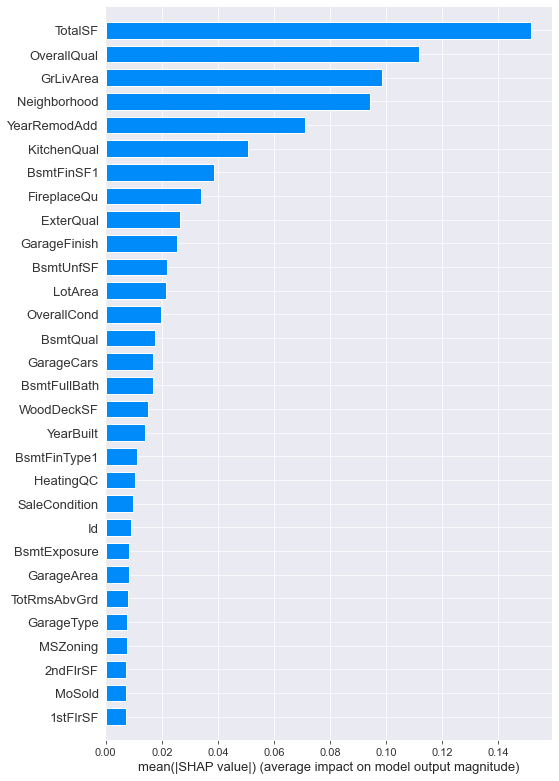

In [19]:
# Feature importance check, just because I can
importances = model.feature_importances_
print ('Feature importances:', np.array(importances))
print ('Feature names:', np.array(train_pool.get_feature_names()))



shap_values = model.get_feature_importance(train_pool, type='ShapValues')
shap.summary_plot(shap_values[:,:-1], X_train, plot_type='bar', max_display=30)

Prediction and submission

In [20]:
x = model.predict(test_pool)

submission = pd.DataFrame({'Id': test['Id'],'SalePrice':x})
#save the file to your directory
submission.to_csv('submission.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 1456 to 2914
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   object 
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  Overa